# Introduction to the VAPr package for the aggregation and analysis of genomic variant annotations 

#### Author: C. Mazzaferro, A. Mark, A. Birmingham, Kathleen Fisch
#### Contact Email: kfisch@ucsd.edu
#### Last Update: November 2017

## Background

The VAPr package retrieves variant information from [ANNOVAR](http://annovar.openbioinformatics.org/en/latest/) and [myvariant.info](myvariant.info) and consolidates it into a single local database for ease of use in investigating and filtering variant findings. The aggregated information is structured into lists of python dictionaries, with each variant being described by a multi-level dictionary. This approach flexibly accommodates the wide variety of information attributes available for different variants.  Further, this specific format permits its parsing to a MongoDb instance (dictionaries are the python representation of JSON objects), which enables the user to efficiently store, query and filter such data. 

Finally, the package also has the added functionality to create csv and vcf files from MongoDB. The built-in filters allow the user to rapidly query data that meets certain criteria as a list of documents, which can the be transformed into more widely accepted formats such as vcf and csv files. It should be noted that here, the main differential the package offers is the ability to write these files preserving all the annotation data. In the vcf files, for instance, outputs will have a 'Otherinfo' column where all the data coming from ANNOVAR and myvariant.info is condensed (while still preserving its structure). 

Having the data stored in a database offers a variety of benefits. In particular, it enables the user to set customized queries and rapidly iterate over a specific procedure and get maximum reproducibility. It also enables the storage of data coming from different sources, and its rapid access. 

**Notes on required software**

the following libraries will be installed upon installing VAPr:
- myvariant
- pymongo
- pyvcf

Other libraries that are needed, but should natively e installed on most OS: 

- Pandas
- Numpy

Further, a MongoDB database must be set up. Refer to the documentation page for more information. 
Similarly, ANNOVAR must be downloaded, alongside with its supporting databases (also listed on the documentation page).

# Flowchart Diagram

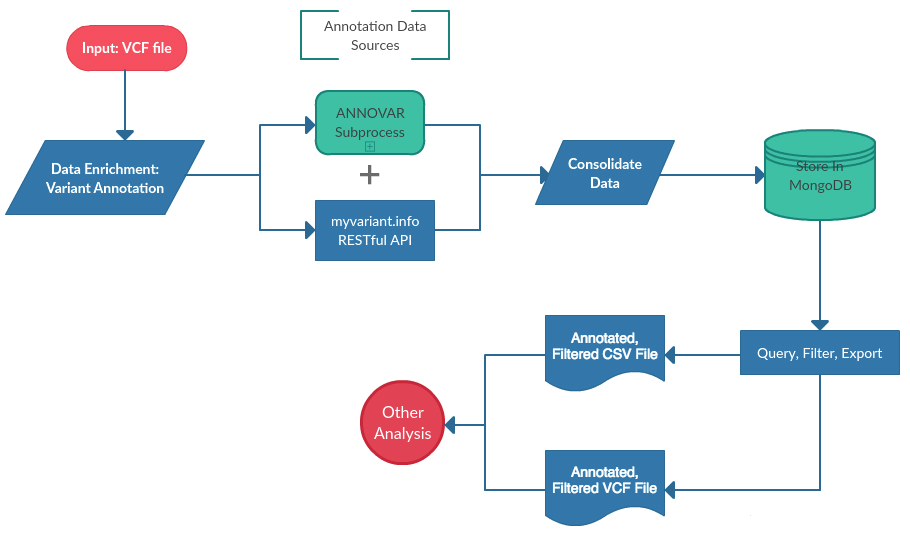

In [1]:
import os
from IPython.display import Image, display, HTML
Image(filename=os.path.dirname(os.path.realpath('__file__')) + '/simpler.jpg')

## Import libraries

In [1]:
from VAPr import vapr_core
import os

In [2]:
IN_PATH = "/path/to/vcf"
OUT_PATH = "/path/to/out"
ANNOVAR_PATH = "/path/to/annovar"
MONGODB = 'VariantDatabase'
COLLECTION = 'CEU_trio_01012018'

In [3]:
annotator = vapr_core.VaprAnnotator(input_dir=IN_PATH,
                                    output_dir=OUT_PATH,
                                    mongo_db_name=MONGODB,
                                    mongo_collection_name=COLLECTION,
                                    build_ver='hg19',
                                    vcfs_gzipped=False,
                                    annovar_install_path=ANNOVAR_PATH)

## Run Annovar and MyVariant.info queries, upload variant annotations to MongoDB

The following command runs Annovar and processes the annotations, gets MyVariant.info annotations, merges the annotations by HGVS id into a JSON document, and uploads the documents to a MongoDB database. VAPr will also automatically include sample information from the VCF as well.

In [ ]:
dataset = annotator.annotate(num_processes=8)

<a id = "export2"></a>
## Skip Annovar step, export only MyVariant data to MongoDB

This will export variant data from a vcf file to MongoDB, annotating variants solely with MyVariant.info. This method does not require annovar, and may result in some empty variant documents.

In [ ]:
dataset_light = annotator.annotate_lite(num_processes=8

## Query Rare Deleterious Variants
You will not have to instantiate a VaprDataset object if you still have your VaprAnnotator object. But for the purpose of demonstrating that the VaprDataset object will make the MongoDB connection to interact with your database, we will do so:

In [4]:
dataset = vapr_core.VaprDataset(MONGODB, COLLECTION)

In [3]:
rare_deleterious_variants = dataset.get_rare_deleterious_variants()
rare_deleterious_variants[0]

{'1000g2015aug_all': 0.00958466,
 '_id': ObjectId('5a0c9c1685db9e1d7060676f'),
 'alt': 'A',
 'cadd': {'1000g': {'af': 0.01, 'amr': 0.01, 'eur': 0.03},
  '_license': 'http://goo.gl/bkpNhq',
  'esp': {'af': 0.01, 'afr': 0.003, 'eur': 0.013},
  'gerp': {'n': 4.46, 'rs': 321.9, 'rs_pval': 1.53314e-48, 's': 4.46},
  'phred': 14.73,
  'polyphen': {'cat': 'benign', 'val': 0.002},
  'sift': {'cat': 'tolerated', 'val': 1}},
 'chr': '1',
 'dbsnp': {'_license': 'https://goo.gl/Ztr5rl', 'rsid': 'rs72703203'},
 'end': 109810200,
 'exonicfunc_knowngene': 'nonsynonymous SNV',
 'func_knowngene': 'exonic',
 'gene_knowngene': 'CELSR2',
 'hgvs_id': 'chr1:g.109810200G>A',
 'ref': 'G',
 'samples': [{'AD': [19, 19],
   'genotype': '0/1',
   'genotype_likelihoods': [1008.0, 0.0, 977.0],
   'genotype_subclass_by_class': {'heterozygous': 'reference'},
   'sample_id': 'NA12891'},
  {'AD': [18, 15],
   'genotype': '0/1',
   'genotype_likelihoods': [762.0, 0.0, 927.0],
   'genotype_subclass_by_class': {'heterozyg

## Notes on Variant Filtering & Output Files

Here we implement three different filters that allow for the retrieval of specific variants. The filters are implemented as MongoDB queries, and are designed to provide the user with a set of relevant variants. A template is provided for defining custom queries as well. 
The output of the queries is a list of dictionaries (JSON documents), where each dictionary contains a single variant document and its annotations. 

Further, the package allows the user to parse these variants into an annotated csv or vcf file. 
If needed, annotated, unfiltered vcf and csv files can also be created. They will have the same length (number of variants) as the original files, but will contain much more complete annotation data coming from myvariant.info and ANNOVAR databases. 

## Filter #1: Rare deleterious variants

 - criteria 1: 1000 Genomes (ALL) allele frequency (Annovar) < 0.05 or info not available
 - criteria 2: ESP6500 allele frequency (MyVariant.info - CADD) < 0.05 or info not available
 - criteria 3: cosmic70 (MyVariant.info) information is present
 - criteria 4: Func_knownGene (Annovar) is exonic, splicing, or both
 - criteria 5: ExonicFunc_knownGene (Annovar) is not "synonymous SNV"

In [21]:
# Apply filter.
rare_deleterious_variants = dataset.get_rare_deleterious_variants()

## Filter #2: Known disease variants

- criteria: cosmic70 (MyVariant.info) information is present or ClinVar data is present and clinical significance is not Benign or Likely Benign

In [22]:
# Apply filter.
known_disease_variants = dataset.get_known_disease_variants()

In [23]:
len(known_disease_variants)

14095

## Filter #3: Deleterious compound heterozygous variants
- criteria 1: genotype_subclass_by_class (VAPr) is compound heterozygous
- criteria 2: CADD phred score (MyVariant.info - CADD) > 10

In [ ]:
# Apply filter
deleterious_compound_heterozygous = dataset.get_deleterious_compound_heterozygote_variants()

## Filter #4: De novo variants
- criteria 1: Variant present in proband
- criteria 2: Variant not present in either ancestor-1 or ancestor-2

In [5]:
# Apply filter.
denovo_variants = dataset.get_de_novo_variants(proband="NA12878",
                                               ancestor1="NA12891",
                                               ancestor2="NA12892")
denovo_variants[0]

{'1000g2015aug_all': 0.838059,
 '_id': ObjectId('5a0c9c1685db9e1d706067f4'),
 'alt': 'T',
 'chr': '1',
 'dbsnp': {'_license': 'https://goo.gl/Ztr5rl', 'rsid': 'rs438060'},
 'end': 110226541,
 'func_knowngene': 'UTR3',
 'gene_knowngene': 'GSTM2',
 'genedetail_knowngene': 'uc010ovt.2:c.*730A>T',
 'hgvs_id': 'chr1:g.110226541A>T',
 'ref': 'A',
 'samples': [{'AD': [0, 1],
   'genotype': '1/1',
   'genotype_likelihoods': [66.0, 6.0, 0.0],
   'genotype_subclass_by_class': {'homozygous': 'alt'},
   'sample_id': 'NA12878'}],
 'start': 110226541,
 'wellderly': {'_license': 'https://goo.gl/e8OO17',
  'alleles': [{'freq': 0.99}, {'freq': 0.01}]}}

## Create your own filter

As long as you have a MongoDB instance running, filtering can be perfomed through pymongo as shown by the code below. If a list is intended to be created from it, simply add: `filter = list(filter)`

If you'd like to customize your filters, a good idea would be to look at the available fields to be filtered. Looking at the myvariant.info [documentation](http://docs.myvariant.info/en/latest/doc/data.html), you can see what are all the fields avaialble and can be used for filtering. 

In [7]:
from pymongo import MongoClient

client = MongoClient()
db = getattr(client, MONGODB)
collection = getattr(db, COLLECTION)

filtered = collection.find({"$and": [
                                   {"$or": [{"func_knowngene": "exonic"},
                                            {"func_knowngene": "splicing"}]},
                                   {"cosmic70": {"$exists": True}},
                                   {"1000g2015aug_all": {"$lt": 0.05}}
                         ]})
filtered = list(filtered)